<a href="https://colab.research.google.com/github/chyj0805/Project_2/blob/main/colabs/Yujie/Class/StockModelTrainerPredictor_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-dotenv

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import requests
import pandas as pd
import numpy as np
import os
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import mean_squared_error
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model


In [ ]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv

In [ ]:
class StockModelTrainerPredictor:
    def __init__(self, ticker):
        self.ticker = ticker
        self.data = None
        self.api_key = None
        self.load_api_key()

    def load_api_key(self):
        load_dotenv()
        self.api_key = os.environ.get("ALPHA_VANTAGE_API_KEY")
        if self.api_key is None:
            raise ValueError("Alpha Vantage API key is not set in the environment.")

    def get_stock_historical_data_with_MACD(self, interval="daily", series_type="close"):
        base_url = "https://www.alphavantage.co/query"

        # Fetch Stock Historical Data
        stock_params = {
            "function": "TIME_SERIES_DAILY",
            "symbol": self.ticker,
            "apikey": self.api_key,
            "outputsize": "full",
            "datatype": "json"
        }

        response = requests.get(base_url, params=stock_params)
        stock_data = response.json()

        if "Time Series (Daily)" not in stock_data:
            print("Error fetching stock data. Check your API key and stock symbol.")
            return None

        time_series = stock_data["Time Series (Daily)"]
        stock_list = []

        for date, details in time_series.items():
            row = {
                "Date": date,
                "Open": details["1. open"],
                "High": details["2. high"],
                "Low": details["3. low"],
                "Close": details["4. close"],
                "Volume": details["5. volume"]
            }
            stock_list.append(row)

        stock_df = pd.DataFrame(stock_list)
        stock_df["Date"] = pd.to_datetime(stock_df["Date"])
        stock_df = stock_df.sort_values(by="Date")

        macd_params = {
          "function": "MACD",
          "symbol": self.ticker,
          "interval": interval,
          "series_type": series_type,
          "apikey": self.api_key
             }

        macd_response = requests.get(base_url, params=macd_params)
        macd_data = macd_response.json()

        if 'Technical Analysis: MACD' not in macd_data:
              print("Error fetching MACD data. Check your API key and stock symbol.")
              return None

        macd_series = macd_data['Technical Analysis: MACD']
        macd_list = []

        for date, details in macd_series.items():
            row = {
                "Date": date,
                "MACD_Signal": details['MACD_Signal'],
                "MACD_Hist": details['MACD_Hist'],
                "MACD": details['MACD']
            }
            macd_list.append(row)

        macd_df = pd.DataFrame(macd_list)
        macd_df["Date"] = pd.to_datetime(macd_df["Date"])
        macd_df = macd_df.sort_values(by="Date")

        # Merge stock and MACD data
        stock_df = pd.merge(stock_df, macd_df, on='Date', how='left')

        return stock_df

    def get_combined_data(self, interval="daily", series_type="close"):
        stock_macd_df = self.get_stock_historical_data_with_MACD(interval, series_type)
         # Get the latest date from stock_macd_df
        latest_stock_date = stock_macd_df['Date'].max()

        # Fetch Federal Funds Rate Data
        rate_url = f'https://www.alphavantage.co/query?function=FEDERAL_FUNDS_RATE&interval={interval}&apikey={self.api_key}'
        rate_data = requests.get(rate_url).json()

        if 'data' not in rate_data:
            print("Error fetching FEDERAL_FUNDS_RATE data. Check your API key.")
            return None

        fed_dates = [entry['date'] for entry in rate_data['data']]
        fed_rates = [float(entry['value']) for entry in rate_data['data']]
        fed_df = pd.DataFrame({'Federal Funds Rate': fed_rates}, index=fed_dates)
        fed_df.index = pd.to_datetime(fed_df.index)
        fed_df.sort_index(ascending=True, inplace=True)

        # Fetch Unemployment Data
        job_url = f'https://www.alphavantage.co/query?function=UNEMPLOYMENT&apikey={self.api_key}'
        job_data = requests.get(job_url).json()

        if 'data' not in job_data:
            print("Error fetching UNEMPLOYMENT data. Check your API key.")
            return None

        job_dates = [entry['date'] for entry in job_data['data']]
        job_rates = [float(entry['value']) for entry in job_data['data']]
        job_df = pd.DataFrame({'Unemployment Rate': job_rates}, index=job_dates)
        job_df.index = pd.to_datetime(job_df.index)
        job_df = job_df.resample('D').ffill()

        # Fetch EMA 20 Data
        ema_url = f'https://www.alphavantage.co/query?function=EMA&symbol={self.ticker}&interval={interval}&time_period=20&series_type={series_type}&apikey={self.api_key}'
        ema_data = requests.get(ema_url).json()
        ema_df = pd.DataFrame(ema_data['Technical Analysis: EMA']).T.reset_index()
        ema_df.columns = ['Date', 'EMA20']
        ema_df['Date'] = pd.to_datetime(ema_df['Date'])
        ema_df.sort_index(ascending=True, inplace=True)

        # Fetch CPI Data
        cpi_url = f'https://www.alphavantage.co/query?function=CPI&interval=monthly&apikey={self.api_key}'
        cpi_r = requests.get(cpi_url)
        cpi_data = cpi_r.json()['data']
        cpi_dates = [entry['date'] for entry in cpi_data]
        cpi_values = [float(entry['value']) for entry in cpi_data]
        cpi_df = pd.DataFrame({'CPI': cpi_values}, index=cpi_dates)
        cpi_df.index = pd.to_datetime(cpi_df.index)
        cpi_df = cpi_df.resample('D').ffill()

        # Merge all DataFrames
        stock_macd_df['Date'] = pd.to_datetime(stock_macd_df['Date'])
        combined_df = pd.merge(stock_macd_df, fed_df, left_on='Date', right_index=True, how='left')
        combined_df = pd.merge(combined_df, job_df, left_on='Date', right_index=True, how='left')
        combined_df = pd.merge(combined_df, ema_df, on='Date', how='left')
        combined_df = pd.merge(combined_df, cpi_df, left_on='Date', right_index=True, how='left')

        # Forward fill any remaining NaNs
        combined_df.fillna(method='ffill', inplace=True)

        # Make sure to keep the latest stock and MACD data
        latest_data = stock_macd_df[stock_macd_df['Date'] == latest_stock_date]
        combined_df.update(latest_data, overwrite=False)
        # Drop rows with NaN values
        combined_df.dropna(inplace=True)

        self.data = combined_df
        return self.data

    def preprocess_data(self):
        # Assuming self.data is a DataFrame containing the required columns
        x = self.data[["Open", "High", "Low", "Volume", "MACD_Signal", "MACD_Hist", "MACD", "Federal Funds Rate", "Unemployment Rate"]].to_numpy()
        y = self.data["Close"].to_numpy()

        scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

        x_scaled = scaler_x.fit_transform(x)
        y_scaled = self.scaler_y.fit_transform(y.reshape(-1, 1))

        sequence_length = 100
        sequences = []
        targets = []

        for i in range(len(y_scaled) - sequence_length - 60):
            sequences.append(x_scaled[i:i + sequence_length])
            targets.append(y_scaled[i + sequence_length:i + sequence_length + 60])

        sequences = np.array(sequences)
        targets = np.array(targets)

        split_ratio = 0.8
        split_index = int(split_ratio * len(sequences))

        x_train = sequences[:split_index]
        y_train = targets[:split_index]
        x_test = sequences[split_index:]
        self.y_test = targets[split_index:]

        val_split_ratio = 0.2
        val_split_index = int((1 - val_split_ratio) * len(x_train))

        x_train_actual = x_train[:val_split_index]
        y_train_actual = y_train[:val_split_index]
        x_val = x_train[val_split_index:]
        y_val = y_train[val_split_index:]

        return x_train_actual, y_train_actual, x_val, y_val, x_test

    def root_mean_squared_error(self, y_true, y_pred):
        return K.sqrt(mean_squared_error(y_true, y_pred))

    def load_model(self, model_path):
        if os.path.exists(model_path):
            self.model = load_model(model_path, custom_objects={'root_mean_squared_error': self.root_mean_squared_error})
            print("Model loaded from ", model_path)
        else:
            print(f"No model found at {model_path}. Consider training a new model.")


    def train_model(self):
        if hasattr(self, 'model'):
            print("Model already loaded. Skipping training.")
            return
        x_train_actual, y_train_actual, x_val, y_val, x_test = self.preprocess_data()

        model_lstm = Sequential()
        model_lstm.add(LSTM(150, return_sequences=False, input_shape=(100, x_test.shape[2])))
        model_lstm.add(Dense(60))

        model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[self.root_mean_squared_error])

        model_lstm.fit(x_train_actual, y_train_actual, epochs=30, batch_size=32, validation_data=(x_val, y_val))

        self.model = model_lstm
        # Save the model with a name based on the stock ticker
        model_path = f"{self.ticker}_model.h5"
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

    def predict_with_pretrained_model(self):
        if not hasattr(self, 'model'):
            print("No model is loaded. Cannot make predictions.")
            return

        _, _, _, _, x_test = self.preprocess_data()
        predictions_scaled = self.model.predict(x_test)
        self.predictions = self.scaler_y.inverse_transform(predictions_scaled)
        return self.predictions
    def make_predictions(self):
        _, _, _, _, x_test = self.preprocess_data()
        predictions_scaled = self.model.predict(x_test)
        self.predictions = self.scaler_y.inverse_transform(predictions_scaled)

    def visualize_results_whole(self):
        # First Day
        plt.figure(figsize=(15, 6))
        y_test_first_day = self.y_test[:, 0]
        y_test_inv_first_day = self.scaler_y.inverse_transform(y_test_first_day)
        predictions_first_day = self.predictions[:, 0]
        plt.plot(y_test_inv_first_day, label='True - First Day')
        plt.plot(predictions_first_day, label='Predicted - First Day')
        plt.title(f'{self.ticker} Stock Price Prediction - First Day')
        plt.xlabel('Trading Day')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        # Last Day
        plt.figure(figsize=(15, 6))
        y_test_last_day = self.y_test[:, -1]
        y_test_inv_last_day = self.scaler_y.inverse_transform(y_test_last_day)
        predictions_last_day = self.predictions[:, -1]
        plt.plot(y_test_inv_last_day, label='True - Last Day')
        plt.plot(predictions_last_day, label='Predicted - Last Day')
        plt.title(f'{self.ticker} Stock Price Prediction - Last Day')
        plt.xlabel('Trading Day')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        # 5th Day
        plt.figure(figsize=(15, 6))
        day_index = 4  # Index 4 corresponds to the 5th day
        y_test_5th_day = self.y_test[:, day_index]
        y_test_inv_5th_day = self.scaler_y.inverse_transform(y_test_5th_day)
        predictions_5th_day = self.predictions[:, day_index]
        plt.plot(y_test_inv_5th_day, label='True - 5th Day')
        plt.plot(predictions_5th_day, label='Predicted - 5th Day')
        plt.title(f'{self.ticker} Stock Price Prediction - 5th Day')
        plt.xlabel('Trading Day')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        # 30th Day
        plt.figure(figsize=(15, 6))
        day_index = 29
        y_test_30th_day = self.y_test[:, day_index]
        y_test_inv_30th_day = self.scaler_y.inverse_transform(y_test_30th_day)
        predictions_30th_day = self.predictions[:, day_index]
        plt.plot(y_test_inv_30th_day, label='True - 30th Day')
        plt.plot(predictions_30th_day, label='Predicted - 30th Day')
        plt.title(f'{self.ticker} Stock Price Prediction - 30th Day')
        plt.xlabel('Trading Day')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def visualize_results_60days(self):
        # Reverse normalize y_test for comparison with the original data
        y_test_inv = self.scaler_y.inverse_transform(self.y_test.squeeze(-1))

        # Choose a random sample of 4 indices between 0 and 1000
        sample_indices = np.random.choice(range(0, 1000), 4, replace=False)

        for sample_index in sample_indices:
            plt.figure(figsize=(10, 6))
            y_true_sample = y_test_inv[sample_index]
            y_pred_sample = self.predictions[sample_index]
            plt.plot(y_true_sample, label='Actual Prices')
            plt.plot(y_pred_sample, label='Predicted Prices')
            plt.xlabel('Days')
            plt.ylabel('Price')
            plt.title(f'{self.ticker} Actual vs. Predicted Prices for the Next 60 Days - Sample {sample_index+1}')
            plt.legend()
            plt.show()

    def calculate_average_rmse(self):
        # Initialize an empty list to store RMSE for each window
        rmse_values = []

        # Loop through each window (from 0 to 59)
        for i in range(60):  # we have 60 windows
            # Extract the i-th window from y_test and predictions, then inverse transform and flatten(for faster caculation)
            y_test_window_original = self.scaler_y.inverse_transform(self.y_test[:, i, :]).flatten()
            predictions_window_original = self.predictions[:, i]

            # Calculate RMSE for this window and append to the list
            rmse = np.sqrt(mean_squared_error(y_test_window_original, predictions_window_original))
            rmse_values.append(rmse)

        # Calculate the average RMSE
        average_rmse = np.mean(rmse_values)
        return print(f'{self.ticker} Average RMSE: {average_rmse}')

    def mean_absolute_percentage_error(self, y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        ape = np.abs((y_true - y_pred) / y_true) * 100
        mape = np.mean(ape)
        return mape

    def calculate_average_mape(self):
        # Initialize an empty list to store MAPE for each window
        mape_values = []


        for i in range(60):  # we have 60 windows
            y_test_window_original = self.scaler_y.inverse_transform(self.y_test[:, i, :]).flatten()
            predictions_window_original = self.predictions[:, i]

            # Calculate MAPE for this window and append to the list
            mape = self.mean_absolute_percentage_error(y_test_window_original, predictions_window_original)
            mape_values.append(mape)

        # Calculate the average MAPE
        average_mape = np.mean(mape_values)
        return print(f'{self.ticker} Average MAPE: {average_mape}')

    def calculate_average_pearson_corr(self):
        # Initialize an empty list to store Pearson correlation coefficients for each window
        corr_values = []


        for i in range(60):  # we have 60 windows
            y_test_window_original = self.scaler_y.inverse_transform(self.y_test[:, i, :]).flatten()
            predictions_window_original = self.predictions[:, i]

            # Calculate Pearson correlation coefficient for this window and append to the list
            corr_coef, _ = pearsonr(y_test_window_original, predictions_window_original)
            corr_values.append(corr_coef)

        # Calculate the average Pearson correlation coefficient
        average_corr = np.mean(corr_values)
        return print(f'{self.ticker} Average Pearson Correlation Coefficient: {average_corr}')

    def predict_next_60_days(self):
        self.get_combined_data()
        sequence_length = 100  # Assume you use the last 100 days of data for sequence length

        last_date = self.data['Date'].iloc[-1]
        future_dates = pd.date_range(start=last_date, periods=61, freq='B').strftime('%Y-%m-%d')[1:]  # Remove the first date which is the last known date

        # Data preprocessing
        new_x = self.data[["Open", "High", "Low", "Volume", "MACD_Signal", "MACD_Hist", "MACD", "Federal Funds Rate", "Unemployment Rate"]].to_numpy()
        scaler_x = MinMaxScaler()
        new_x_scaled = scaler_x.fit_transform(new_x)

        # Here, let's assume self.data['Close'] contains the original closing prices
        original_y = self.data['Close'].to_numpy().reshape(-1, 1)
        scaler_y = MinMaxScaler()
        scaler_y.fit(original_y)  # Fit the scaler on the original closing prices

        # Get the last sequence of data
        last_sequence = new_x_scaled[-sequence_length:]  # Get the last 100 days data
        last_sequence = last_sequence.reshape(1, sequence_length, 9)  # 9 is the number of features

        # Make predictions
        predictions_scaled = self.model.predict(last_sequence)
        predictions = scaler_y.inverse_transform(predictions_scaled)

        # Plotting
        plt.figure(figsize=(14, 7))  # Set the figure size
        plt.plot(future_dates, predictions[0])  # Use future_dates as the x-axis
        plt.title(f"{self.ticker} 60 Days Future Predictions")
        plt.xlabel('Date')
        plt.ylabel('Predicted Close Price')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

        # Show only some of the xticks to reduce clutter
        selected_ticks = future_dates[::10]  # Show every 10th date
        plt.xticks(selected_ticks, rotation=45)


        plt.show()


ticker = "IYE"
predictor = StockPredictor(ticker)
predictor.get_combined_data()
print(predictor.data)

           Date     Open     High      Low    Close  Volume MACD_Signal  \
33   2000-08-03  49.1900  49.1900  48.5000  48.5300    1500     -0.2024   
34   2000-08-04  47.7500  48.5300  47.7500  48.5300    2300     -0.1809   
35   2000-08-07  48.8800  49.2800  48.8800  49.1300    1000     -0.1578   
36   2000-08-08  49.0300  49.3100  49.0300  49.3100     400     -0.1339   
37   2000-08-09  50.0600  50.4100  50.0000  50.2200    7200     -0.1076   
...         ...      ...      ...      ...      ...     ...         ...   
5835 2023-08-28  46.2100  46.7200  46.1140  46.3900  361019      0.5717   
5836 2023-08-29  46.4800  46.6125  46.0700  46.5600  386931      0.5390   
5837 2023-08-30  46.7300  46.9150  46.6100  46.8100  181727      0.5161   
5838 2023-08-31  46.9800  46.9800  46.5600  46.8500  174626      0.5000   
5839 2023-09-01  47.3300  47.8500  47.3300  47.7800  587404      0.5026   

     MACD_Hist     MACD  Federal Funds Rate  Unemployment Rate    EMA20  \
33      0.0831  -0.1194 

Model loaded from  IYE_beta_model.h5
Model already loaded. Skipping training.
36/36 [==============================] - 3s 70ms/step


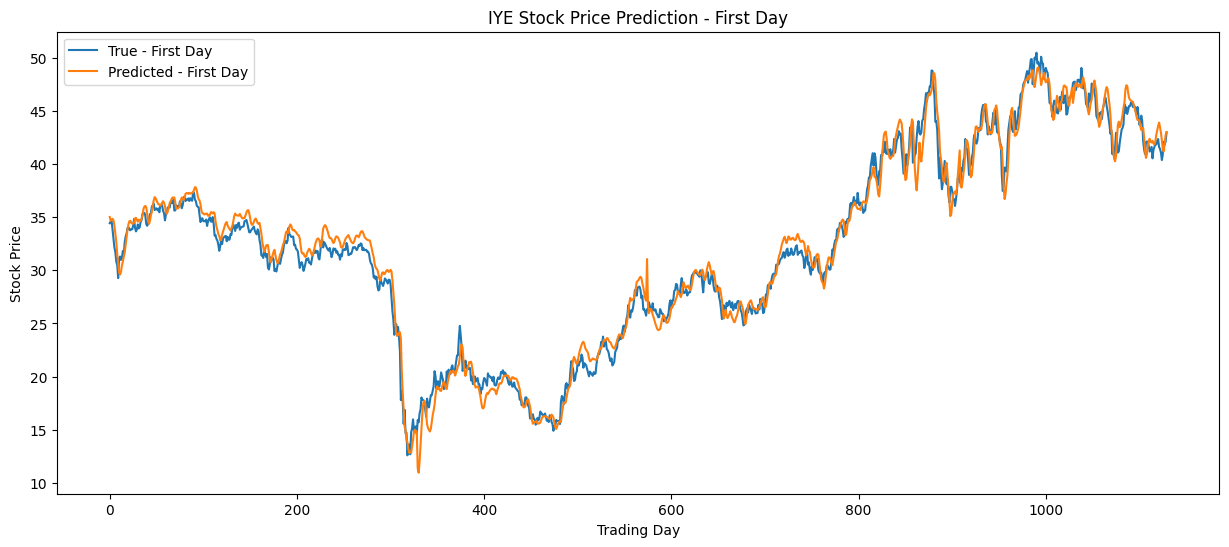

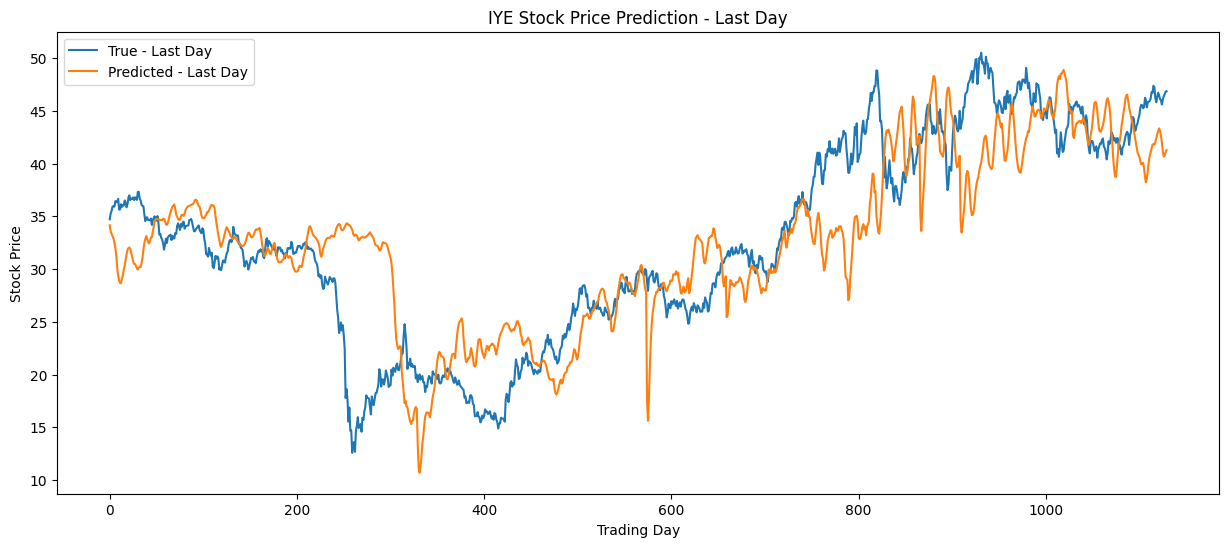

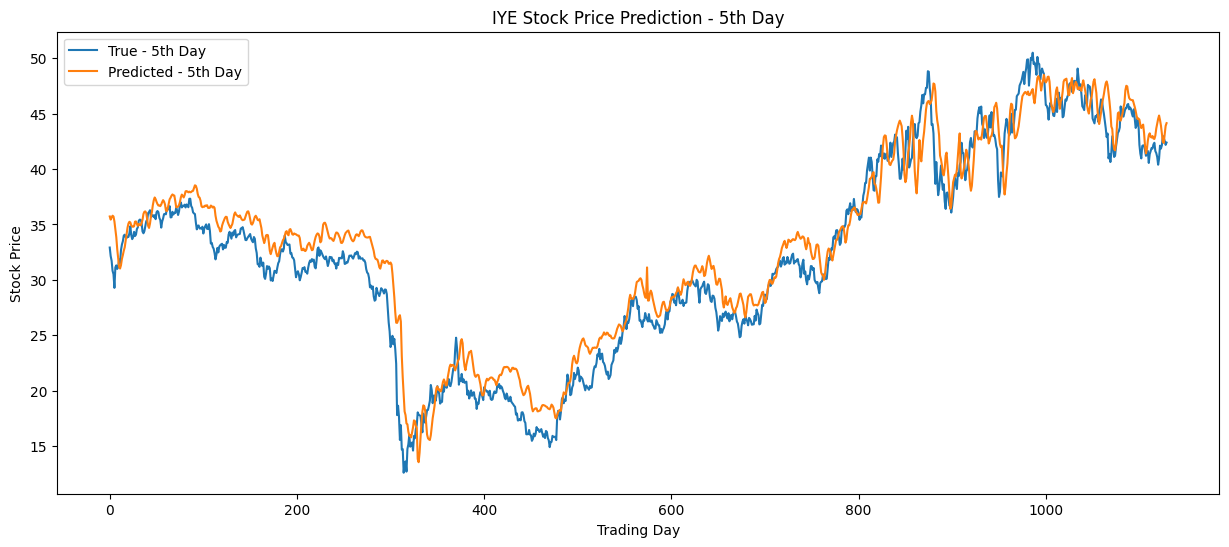

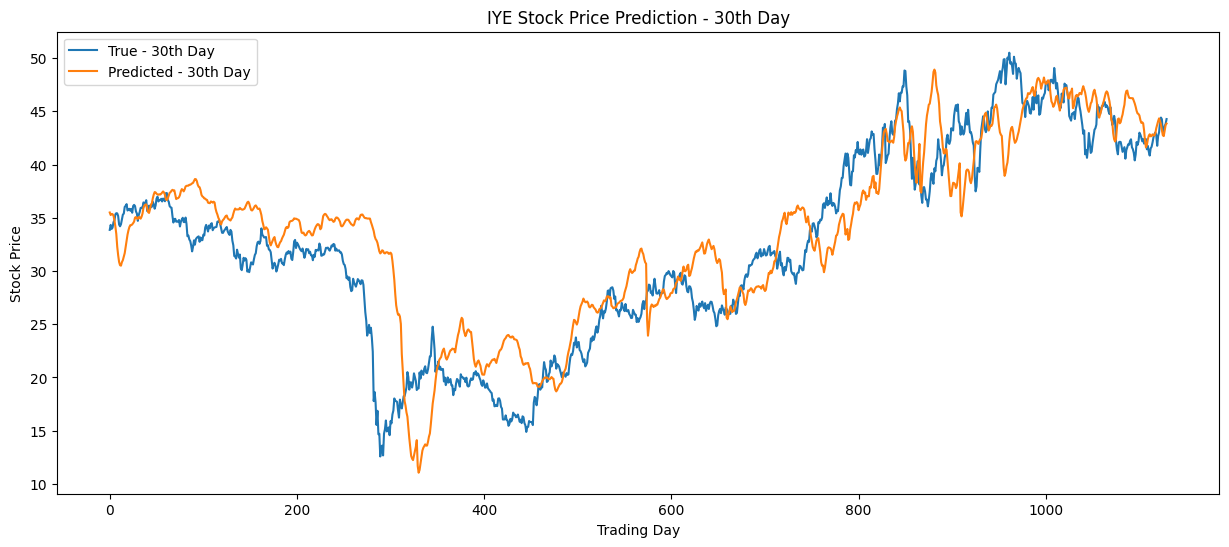

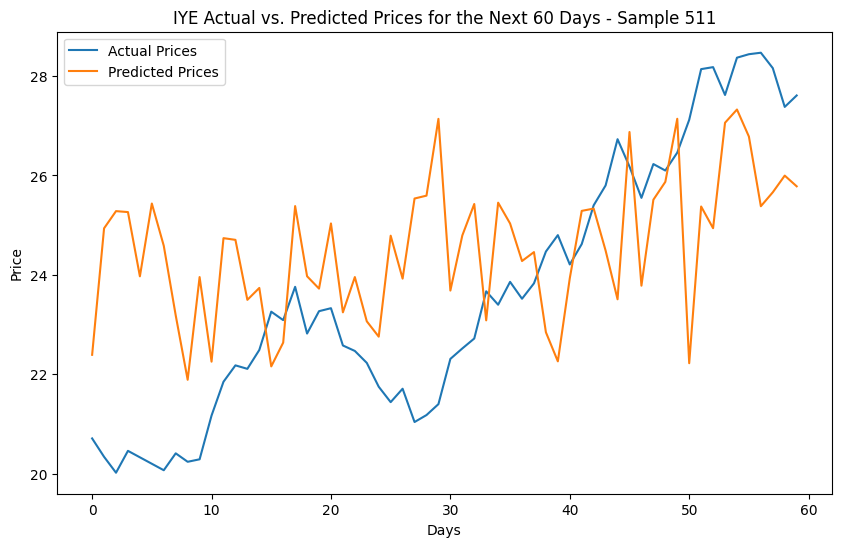

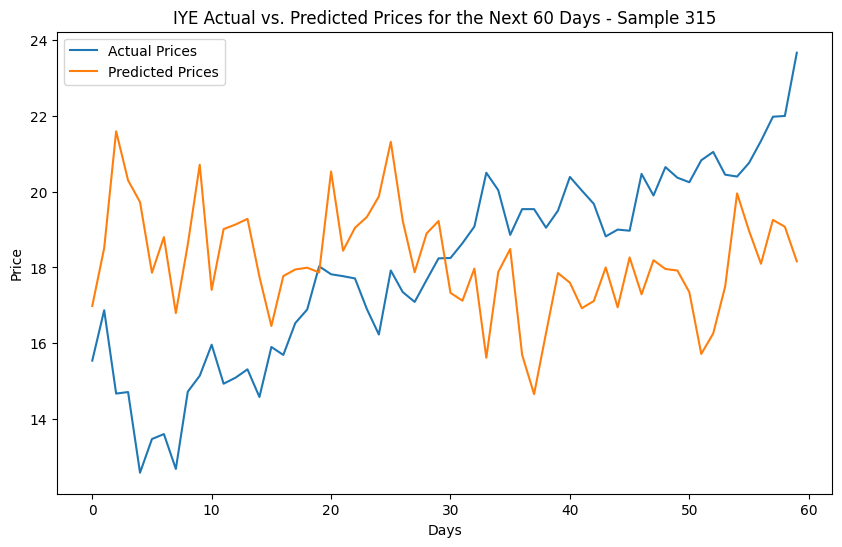

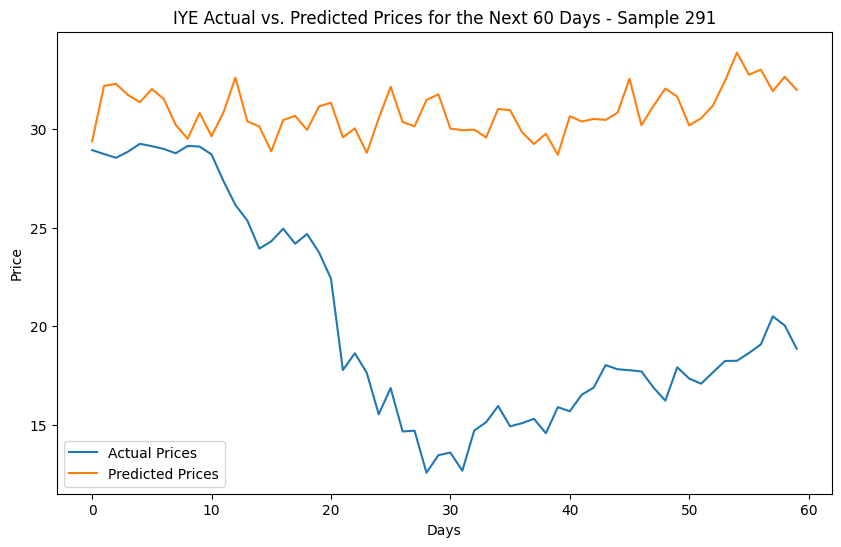

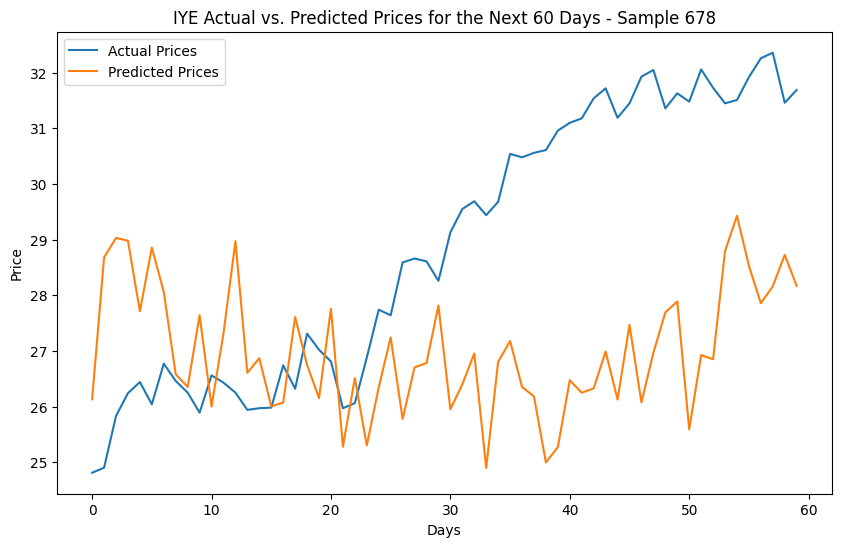

IYE Average RMSE: 4.204130172729492
IYE Average MAPE: 11.524224655667942
IYE Average Pearson Correlation Coefficient: 0.8904954263665648
1/1 [==============================] - 0s 35ms/step


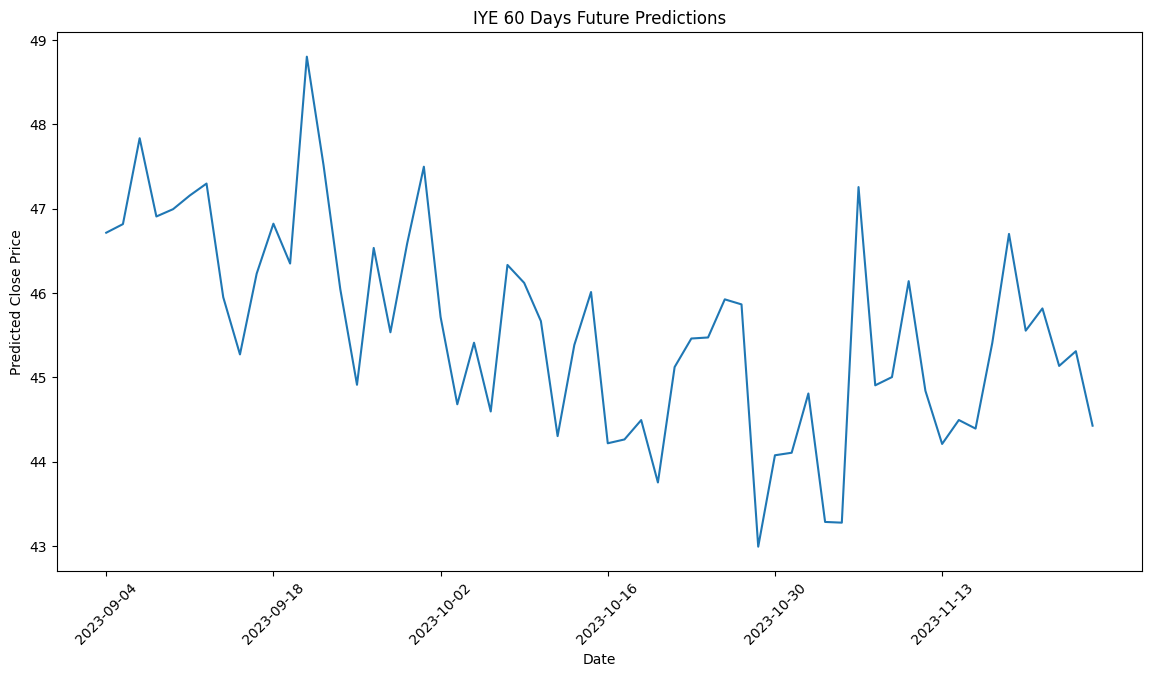

In [ ]:
# 1. Instantiate the StockPredictor Class
ticker = "IYE"  # Replace with the stock ticker you want to predict
model_path = "IYE_beta_model.h5"  # Path to save the model

StockModelTrainerPredictor = StockModelTrainerPredictor(ticker)

# 2. Fetch Stock Data and Other Economic Indicators
StockModelTrainerPredictor.get_combined_data()

# 3. Load Pretrained Model (if available) Skip step 3 if you want to train your model
StockModelTrainerPredictor.load_model(model_path)

# 4. Train the Model (if no pretrained model exists)
StockModelTrainerPredictor.train_model()

# Save the model (if you have trained a new one)
StockModelTrainerPredictor.model.save(model_path)

# 5. Make Predictions
StockModelTrainerPredictor.predict_with_pretrained_model()

# Or use make_predictions (they do the same thing but make_predictions doesn't check if a model is already loaded)
# stock_predictor.make_predictions()

# 6. Visualize the Results
StockModelTrainerPredictor.visualize_results_whole()
StockModelTrainerPredictor.visualize_results_60days()

# 7. Evaulation
StockModelTrainerPredictor.calculate_average_rmse()
StockModelTrainerPredictor.calculate_average_mape()
StockModelTrainerPredictor.calculate_average_pearson_corr()

# 8. Predict the future 60 day
StockModelTrainerPredictor.predict_next_60_days()

In [ ]:
StockModelTrainerPredictor.get_combined_data()

,Date,Open,High,Low,Close,Volume,MACD_Signal,MACD_Hist,MACD,Federal Funds Rate,Unemployment Rate,EMA20,CPI
33,2000-08-03,49.1900,49.1900,48.5000,48.5300,1500,-0.2024,0.0831,-0.1194,6.45,4.1,9.5533,172.800
34,2000-08-04,47.7500,48.5300,47.7500,48.5300,2300,-0.1809,0.0859,-0.0950,6.44,4.1,9.5671,172.800
35,2000-08-07,48.8800,49.2800,48.8800,49.1300,1000,-0.1578,0.0925,-0.0652,6.46,4.1,9.5910,172.800
36,2000-08-08,49.0300,49.3100,49.0300,49.3100,400,-0.1339,0.0956,-0.0383,6.44,4.1,9.6161,172.800
37,2000-08-09,50.0600,50.4100,50.0000,50.2200,7200,-0.1076,0.1053,-0.0023,6.48,4.1,9.6561,172.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2023-08-28,46.2100,46.7200,46.1140,46.3900,361019,0.5717,-0.1649,0.4068,5.33,3.8,45.9765,305.109
5836,2023-08-29,46.4800,46.6125,46.0700,46.5600,386931,0.5390,-0.1309,0.4081,5.33,3.8,46.0321,305.109
5837,2023-08-30,46.7300,46.9150,46.6100,46.8100,181727,0.5161,-0.0917,0.4244,5.33,3.8,46.1062,305.109
5838,2023-08-31,46.9800,46.9800,46.5600,46.8500,174626,0.5000,-0.0645,0.4355,5.33,3.8,46.1770,305.109
